#EmoReflector
This project involves a social-interactive robot that provides the elderly by detecting their emotions to help them deal with it. To develop a machine-learning algorithm, PyTorch will be used.

##1. Load and Preprocess the Dataset


To load the dataset stored in google drive, the dataset must be mounted in Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After mounting, the necessary packages for performing the deep-learning part must be imported as this will be used to insert into the Raspberry Pi.

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

Graphics Preprocessing Units (GPU) divides tasks into smaller sub-tasks that are distributing among several processing cores. This results in faster processing of intensive high-resolution images and graphics like the data that will be used in our project.

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

As the dataset was downloaded and not pre-installed in Pytorch, an image dataset was loaded. After loading the dataset, it has been preprocessed by removing the unnecessary column, dropping rows with missing values in 'label' column, renaming 'label' column to 'emotion' to make it clearer and finally, adding a necessary column 'is_negative' that classifies whether the emotions are negative or non-negative emotion. As our robot will only respond to negative emotions, adding 'is_negative' is a crucial step.  

In [ ]:
csv_file = '/content/drive/My Drive/EmoReflector files/facedataset.csv'
img_dir = '/content/drive/My Drive/EmoReflector files/dataset'

class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Drop the 'Unnamed: 0' column
        if 'Unnamed: 0' in self.data.columns:
            self.data = self.data.drop(columns=['Unnamed: 0'])

        # Drop rows with missing values in the 'label' column
        self.data = self.data.dropna(subset=['label'])

        # Rename 'label' column to 'emotion' to make it clearer that this label is for emotions
        self.data = self.data.rename(columns={'label': 'emotion'})

        # Remove rows where the label is 'Ahegao'
        self.data = self.data[self.data['emotion'].str.lower() != 'ahegao']

        # Add another column of binary classification showing whether it is negative emotion or not
        self.data['is_negative'] = self.data['emotion'].apply(self.neg_nonneg_classifier)

    # Define neg_nonneg_classifier as a method of the class
    def neg_nonneg_classifier(self, emotion):
        negative_emotions = ['angry', 'sad']
        nonnegative_emotions = ['neutral', 'happy', 'surprise']

        if emotion.lower() in negative_emotions:
            return 1  # 1 for negative emotions
        elif emotion.lower() in nonnegative_emotions:
            return 0  # 0 for non-negative emotions
        else:
            raise ValueError(f"Unexpected emotion: {emotion}")  # This is used for handling unexpected labels

    # Shows how many data in the dataset
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path from the dataset and convert it into RGB format
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        # Get what emotion is of the corresponding image
        emotion = self.data.iloc[idx, 1]

        # Get what type of emotion the corresponding image is (whether it is negative or non-negative emotion)
        is_negative = self.data.iloc[idx, 2]

        # Apply image transformations (shown in the next step)
        if self.transform:
            image = self.transform(image)

        return image, emotion, is_negative

Transformations are necessary to enhance the performance of our machine-learning model. It resizes all the images into 128 x 128 pixels, transforms the PIL images or NumPy array into tensors to scale the values accordingly and to normalize the tensor image by adjusting the pixels with a mean = 0.5 and standard deviation = 0.5.

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

To check whether the loading and preprocessing was successful, a dataset was created and tested.

Note: Our dataset consists of 14248 files.

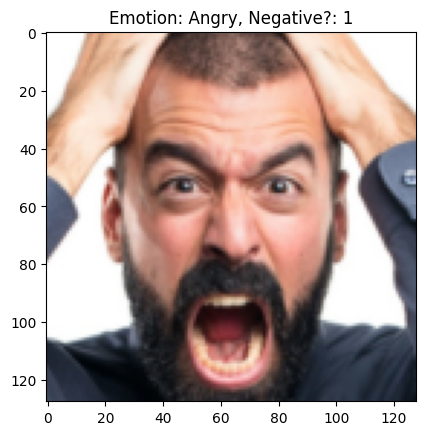

In [ ]:
# Create the dataset
dataset = ImageDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

# Testing data
image, emotion, is_negative = dataset[14247] # Choose any number from 0 to 14247

# Convert tensor to numpy array
image_np = image.permute(1, 2, 0).numpy()

# Undo/reverse normalization to make the tensor back to image
image_np = (image_np * 0.5) + 0.5

# Clip values to be between 0 and 1 (just in case, to ensure that the pixels fall within valid pixel ranges to avoid incorrect visual outputs)
image_np = np.clip(image_np, 0, 1)

# Display the image
plt.imshow(image_np)
plt.title(f"Emotion: {emotion}, Negative?: {is_negative}")
plt.show()

This is to walkthrough how many contents are in our image data directory (extra information).

In [ ]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(img_dir)

There are 5 directories and 0 images in '/content/drive/My Drive/EmoReflector files/dataset'.
There are 0 directories and 1313 images in '/content/drive/My Drive/EmoReflector files/dataset/Angry'.
There are 0 directories and 3934 images in '/content/drive/My Drive/EmoReflector files/dataset/Sad'.
There are 0 directories and 1234 images in '/content/drive/My Drive/EmoReflector files/dataset/Surprise'.
There are 0 directories and 4027 images in '/content/drive/My Drive/EmoReflector files/dataset/Neutral'.
There are 0 directories and 3740 images in '/content/drive/My Drive/EmoReflector files/dataset/Happy'.
